In [1]:
from __future__ import print_function
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import pandas as pd
import glob
import mmmpy
#import cartopy.crs as ccrs
#import cartopy.feature as cfeature
#from cartopy.io.img_tiles import StamenTerrain
#import pygrib
import os, gzip, shutil, glob, tempfile
from contextlib import contextmanager
#import pyart
%matplotlib inline

# Convert the orography into cf compliance format for CDO regridding

In [5]:
orog = xr.open_dataset('data/orography.nc')

# pick your 2D lat/lon names:
for lat_name in ["lat","latitude","XLAT"]:
    if lat_name in orog: break
for lon_name in ["lon","longitude","XLONG"]:
    if lon_name in orog: break

lat2d = orog[lat_name]
lon2d = orog[lon_name]

# normalize dim names to (y,x)
y_dim, x_dim = lat2d.dims
lat2d = lat2d.rename({y_dim:"y", x_dim:"x"})
lon2d = lon2d.rename({y_dim:"y", x_dim:"x"})

grid = xr.Dataset(
    coords={
        "lat": (("y","x"), lat2d.data, {"standard_name":"latitude","units":"degrees_north"}),
        "lon": (("y","x"), lon2d.data, {"standard_name":"longitude","units":"degrees_east"}),
    },
    data_vars={
        "dummy": (("y","x"), np.ones(lat2d.shape, np.float32), {"coordinates":"lon lat"})
    },
)

grid.to_netcdf("data/orography_grid_cf.nc")

# Reading a sample regridded MRMS grib data

<xarray.Dataset> Size: 1MB
Dimensions:        (time: 1, y: 256, x: 288, alt: 1)
Coordinates:
  * time           (time) float64 8B 2.02e+07
    lon            (y, x) float64 590kB ...
    lat            (y, x) float64 590kB ...
  * alt            (alt) float64 8B 500.0
Dimensions without coordinates: y, x
Data variables:
    param58.3.209  (time, alt, y, x) float32 295kB ...
Attributes:
    CDI:                       Climate Data Interface version 2.5.0 (https://...
    Conventions:               CF-1.6
    history:                   Fri Aug 15 18:56:29 2025: cdo -P 16 -f nc rema...
    CDO:                       Climate Data Operators version 2.5.0 (https://...
    cdo_openmp_thread_number:  16


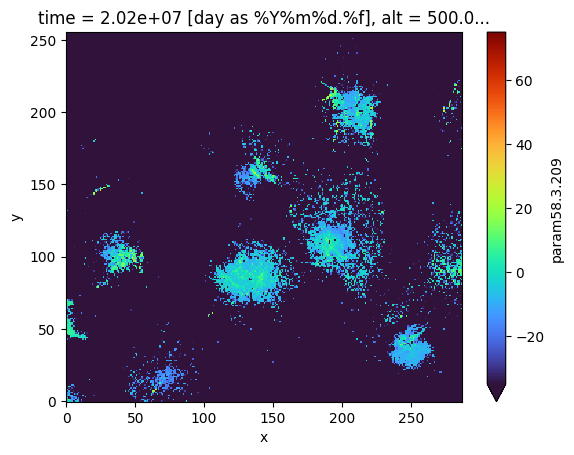

In [10]:
ds = xr.open_dataset('data/testout_on_orog.nc')
print(ds)
ds['param58.3.209'].isel(time=0,alt=0).plot(vmin=-35,vmax=75,cmap='turbo')

In [13]:
ds.lon

<xarray.DataArray 'lon' (y: 256, x: 288)> Size: 590kB
[73728 values with dtype=float64]
Coordinates:
    lon      (y, x) float64 590kB ...
    lat      (y, x) float64 590kB ...
Dimensions without coordinates: y, x
Attributes:
    standard_name:        longitude
    long_name:            longitude
    units:                degrees_east
    _CoordinateAxisType:  Lon

# Possible extract and read the grib2 MRMS data

In [55]:
def open_mfdataset_grib2_gz(gz_files, *, engine="cfgrib", chunks="auto",
                            backend_kwargs=None, concat_dim="time", combine="nested",
                            parallel=True):
    backend_kwargs = {"indexpath": ""} | (backend_kwargs or {})
    tmp = tempfile.TemporaryDirectory(prefix="grib_unz_")
    out_paths = []
    for p in gz_files:
        out = os.path.join(tmp.name, os.path.basename(p)[:-3])  # strip ".gz"
        with gzip.open(p, "rb") as fin, open(out, "wb") as fout:
            shutil.copyfileobj(fin, fout)
        out_paths.append(out)

    ds = xr.open_mfdataset(
        out_paths,
        engine=engine,
        chunks=chunks,
        combine=combine,
        concat_dim=concat_dim,
        backend_kwargs=backend_kwargs,
        parallel=parallel,
    )
    return ds, tmp

In [56]:
files = sorted(glob.glob("data/MRMS_grib_data/CONUS/MergedReflectivityAtLowestAltitude_00.50/20201014/*.grib2.gz", recursive=True))
files

['data/MRMS_grib_data/CONUS/MergedReflectivityAtLowestAltitude_00.50/20201014/MRMS_MergedReflectivityAtLowestAltitude_00.50_20201014-211637.grib2.gz',
 'data/MRMS_grib_data/CONUS/MergedReflectivityAtLowestAltitude_00.50/20201014/MRMS_MergedReflectivityAtLowestAltitude_00.50_20201014-211840.grib2.gz',
 'data/MRMS_grib_data/CONUS/MergedReflectivityAtLowestAltitude_00.50/20201014/MRMS_MergedReflectivityAtLowestAltitude_00.50_20201014-212041.grib2.gz',
 'data/MRMS_grib_data/CONUS/MergedReflectivityAtLowestAltitude_00.50/20201014/MRMS_MergedReflectivityAtLowestAltitude_00.50_20201014-212236.grib2.gz',
 'data/MRMS_grib_data/CONUS/MergedReflectivityAtLowestAltitude_00.50/20201014/MRMS_MergedReflectivityAtLowestAltitude_00.50_20201014-212439.grib2.gz',
 'data/MRMS_grib_data/CONUS/MergedReflectivityAtLowestAltitude_00.50/20201014/MRMS_MergedReflectivityAtLowestAltitude_00.50_20201014-212637.grib2.gz',
 'data/MRMS_grib_data/CONUS/MergedReflectivityAtLowestAltitude_00.50/20201014/MRMS_MergedRefle

In [59]:
ds, tmp = open_mfdataset_grib2_gz(files, chunks="auto")

ECCODES ERROR   :  Key dataTime (unpack_long): Truncating time: non-zero seconds(38) ignored
ECCODES ERROR   :  Key dataTime (unpack_long): Truncating time: non-zero seconds(39) ignored
ECCODES ERROR   :  Key dataTime (unpack_long): Truncating time: non-zero seconds(38) ignored
ECCODES ERROR   :  Key dataTime (unpack_long): Truncating time: non-zero seconds(38) ignored
ECCODES ERROR   :  Key dataTime (unpack_long): Truncating time: non-zero seconds(39) ignored
ECCODES ERROR   :  Key dataTime (unpack_long): Truncating time: non-zero seconds(38) ignored
ECCODES ERROR   :  Key dataTime (unpack_long): Truncating time: non-zero seconds(39) ignored
ECCODES ERROR   :  Key dataTime (unpack_long): Truncating time: non-zero seconds(40) ignored
ECCODES ERROR   :  Key dataTime (unpack_long): Truncating time: non-zero seconds(39) ignored
ECCODES ERROR   :  Key dataTime (unpack_long): Truncating time: non-zero seconds(38) ignored
ECCODES ERROR   :  Key dataTime (unpack_long): Truncating time: non-ze

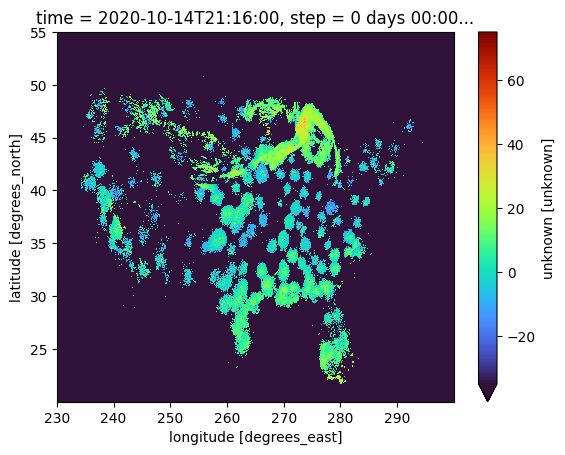

In [60]:
ds.unknown.isel(time=0).plot(vmin=-35,vmax=75,cmap='turbo')

In [ ]:
orography = xr.open_dataset('data/orography.nc')
RTMA_lat = orography.latitude.values    # Nx, Ny 2D arrays
RTMA_lon = orography.longitude.values   # Nx, Ny 2D arrays
orography = orography.set_coords(['latitude', 'longitude'])
orography = orography.orog
orography

<xarray.DataArray 'orog' (y: 256, x: 288)> Size: 295kB
[73728 values with dtype=float32]
Coordinates:
    latitude   (y, x) float64 590kB 40.73 40.73 40.73 40.73 ... 45.31 45.31 45.3
    longitude  (y, x) float64 590kB 279.9 279.9 279.9 ... 289.3 289.3 289.4
Dimensions without coordinates: y, x
Attributes: (12/34)
    GRIB_paramId:                             228002
    GRIB_dataType:                            an
    GRIB_numberOfPoints:                      3744965
    GRIB_typeOfLevel:                         surface
    GRIB_stepUnits:                           1
    GRIB_stepType:                            instant
    ...                                       ...
    GRIB_name:                                Orography
    GRIB_shortName:                           orog
    GRIB_units:                               m
    long_name:                                Orography
    units:                                    m
    standard_name:                            geopotential_height

In [61]:
ds

<xarray.Dataset> Size: 8GB
Dimensions:         (time: 82, latitude: 3500, longitude: 7000)
Coordinates:
  * time            (time) datetime64[ns] 656B 2020-10-14T21:16:00 ... 2020-1...
    step            timedelta64[ns] 8B 00:00:00
    heightAboveSea  float64 8B 500.0
  * latitude        (latitude) float64 28kB 54.99 54.98 54.98 ... 20.02 20.01
  * longitude       (longitude) float64 56kB 230.0 230.0 230.0 ... 300.0 300.0
    valid_time      (time) datetime64[ns] 656B 2020-10-14T21:16:00 ... 2020-1...
Data variables:
    unknown         (time, latitude, longitude) float32 8GB dask.array<chunksize=(1, 3500, 7000), meta=np.ndarray>
Attributes:
    GRIB_edition:            2
    GRIB_centre:             161
    GRIB_centreDescription:  US NOAA Office of Oceanic and Atmospheric Research
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US NOAA Office of Oceanic and Atmospheric Research
    history:                 2025-08-15T17:40 GRIB to CDM+CF via cfgrib-0.9.1...